In [14]:
import pickle
import xgboost as xgb
import mlflow
from hyperopt import hp, Trials, fmin, tpe, STATUS_OK
from pyarrow import parquet
import matplotlib.pyplot as plt

In [66]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
train_df = parquet.read_table('train_data.parquet').to_pandas()
val_df = parquet.read_table('validation_data.parquet').to_pandas()
test_df = parquet.read_table('test_data.parquet').to_pandas()

In [1]:
experiment_name = "Amazon Review XGBoost Full Model"
mlflow.set_experiment(experiment_name)

NameError: name 'mlflow' is not defined

In [3]:
feature_cols = [f"emb_{i}" for i in range(768)]

In [23]:
x_train = train_df[feature_cols]
y_train = train_df['rating_bins']
train_df.shape, x_train.shape, y_train.shape

((508964, 770), (508964, 768), (508964,))

In [24]:
x_val = val_df[feature_cols]
y_val = val_df['rating_bins']
val_df.shape, x_val.shape, y_val.shape

((114517, 770), (114517, 768), (114517,))

In [6]:
sample_size = 50000
sample_x = x_train.sample(n=sample_size)
sample_y = y_train.sample(n=sample_size)
sample_x.shape, sample_y.shape

((50000, 768), (50000,))

In [7]:
from umap import UMAP
import umap.plot
from sklearn.preprocessing import MinMaxScaler

x_scaled = MinMaxScaler().fit_transform(sample_x)
u_map = UMAP(n_components=2, metric="euclidean", n_neighbors=10, min_dist=0.5).fit(x_scaled)
umap.plot.points(u_map, labels=sample_y)
plt.savefig("full_model_embeddings_output.png")
plt.show()

NameError: name 'sample_x' is not defined

In [10]:
def get_sample_weight_dict(df):
    rating_counts = df['rating'].value_counts()
    print(f"rating value counts === {rating_counts}")
    max_rating_count = rating_counts.max()
    weight_dict = (max_rating_count / rating_counts).to_dict()
    print(f"weight_dict === {weight_dict}")
    return weight_dict

sample_weight_dict = get_sample_weight_dict(train_df)
training_sample_weights = train_df['rating'].map(sample_weight_dict).values
val_sample_weights = val_df['rating'].map(sample_weight_dict).values

rating value counts === rating
5.0    401758
4.0     35073
1.0     32560
3.0     23465
2.0     16108
Name: count, dtype: int64
weight_dict === {5.0: 1.0, 4.0: 11.454908334046133, 1.0: 12.339004914004914, 3.0: 17.121585339867888, 2.0: 24.94151974174323}


In [25]:
dmatrix_train = xgb.DMatrix(x_train, label=y_train, weight=training_sample_weights, enable_categorical=True)
dmatrix_val = xgb.DMatrix(x_val, label=y_val, weight=val_sample_weights, enable_categorical=True)
evals = [(dmatrix_train, "train"), (dmatrix_val, "validation")]

In [42]:
params = {
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": ["mlogloss","merror"],
    "num_class":5,
    "objective": "multi:softprob"
}
model = xgb.train(
   params=params,
   dtrain=dmatrix_train,
   num_boost_round=1000,
   evals=evals,
   verbose_eval=50,
   early_stopping_rounds=50

)

[0]	train-mlogloss:1.49821	train-merror:0.55404	validation-mlogloss:1.50330	validation-merror:0.57577
[50]	train-mlogloss:0.86674	train-merror:0.30306	validation-mlogloss:1.09509	validation-merror:0.48610
[100]	train-mlogloss:0.70082	train-merror:0.20329	validation-mlogloss:1.08409	validation-merror:0.47530
[150]	train-mlogloss:0.58016	train-merror:0.13635	validation-mlogloss:1.08761	validation-merror:0.47414
[200]	train-mlogloss:0.48414	train-merror:0.09126	validation-mlogloss:1.09533	validation-merror:0.47229
[239]	train-mlogloss:0.42199	train-merror:0.06693	validation-mlogloss:1.10512	validation-merror:0.47198


In [64]:
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score, balanced_accuracy_score


def get_scores(y_true, y_preds_proba, loss_metric="accuracy"):
    labels=[0,1,2,3,4]
    val_log_loss = log_loss(y_true, y_preds_proba, 
                                sample_weight=val_sample_weights, labels =[0,1,2,3,4]) 
    y_preds = y_preds_proba.argmax(axis=-1) 
    accuracy = balanced_accuracy_score(y_true, y_preds, sample_weight=val_sample_weights)
    
    precision = precision_score(y_true, y_preds, average="weighted",
                                sample_weight=val_sample_weights, labels=labels)
    
    recall = recall_score(y_true, y_preds, average="weighted",
                          sample_weight=val_sample_weights, labels=labels)
    
    f1 = f1_score(y_true, y_preds, average="weighted",
                  sample_weight=val_sample_weights, labels=labels)
    if loss_metric == "log_loss":
        loss = val_log_loss
    else:
        loss = -accuracy
        
    metrics = {
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall" : recall,
            "f1": f1
        }
    return metrics
    

In [48]:
best_iteration = model.best_iteration 
print(f"best_iteration = {best_iteration}")
base_pred_proba = model.predict(dmatrix_val, iteration_range=(0, best_iteration))
metrics = get_scores(y_val, base_pred_proba)
print(params)
print(metrics)

best_iteration = 190
{'booster': 'gbtree', 'device': 'gpu', 'tree_method': 'hist', 'eval_metric': ['mlogloss', 'merror'], 'num_class': 5, 'objective': 'multi:softprob'}
{'loss': 1.0933072415166791, 'accuracy': 0.5280291220633585, 'precision': 0.5093526317252709, 'recall': 0.5280328030626353, 'f1': 0.5108272725675959}


In [63]:
artificat_path = "full_embeddings_fine_tuned"
local_pkl_path = "app/full_embeddings_models/model"
def tune_model(params):
    xgb_model = xgb.train(
        params=params,
        dtrain=dmatrix_train,
        num_boost_round=15000,
        early_stopping_rounds=50,
        evals=evals,
        verbose_eval=50
    )   
    y_pred_proba = xgb_model.predict(dmatrix_val, iteration_range=(0,  xgb_model.best_iteration))   
    with mlflow.start_run(nested=True) as run:
        mlflow.log_params(params)
        metrics = get_scores(y_val, y_pred_proba)
        print(params)
        print(metrics)
        mlflow.log_metrics(metrics)
        mlflow.xgboost.log_model(xgb_model, name=artificat_path)
        pkl_file_name = f"{local_pkl_path}_{run.info.run_id}.pkl"
        pickle.dump(xgb_model, open(pkl_file_name, 'wb'))
        mlflow.log_artifact(local_path=pkl_file_name, artifact_path=artificat_path)
        metrics["status"] = STATUS_OK
        return metrics

In [50]:
def fine_tune_model(ml_flow_run_name, search_space):
    with mlflow.start_run(run_name=ml_flow_run_name):
        # Run optimization
        trials = Trials()
        best_params = fmin(
            fn=tune_model,
            space=search_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials,
            verbose=True,
        )
        # Find and log best results
        best_trial = min(trials.results, key=lambda x: x["loss"])
        # Log optimization results
        mlflow.log_params(best_params)
        mlflow.log_metrics(
            {
                "best_val_log_loss": best_trial["loss"],
                 "best_accuracy": best_trial["accuracy"],
                "best_precision": best_trial["precision"],
                "best_recall" : best_trial["recall"],
                "best_f1": best_trial["f1"],
                "total_trials": len(trials.trials),
                "optimization_completed": 1,
            }
        )

In [2]:
# full embeddings
search_space = {
    "objective": "multi:softprob",
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": "mlogloss",
    "num_class":5,    
    "eta": hp.uniform("eta", 0.01, 0.3),
    "gamma": hp.uniform("gamma", 0, 1.5),
    "max_depth": hp.uniformint("max_depth", 4, 7),
     "min_child_weight": hp.uniformint("min_child_weight", 3, 5),
    "lambda": hp.uniform("lambda", 1, 1.5),
    "alpha": hp.uniform("alpha", 1, 2),   
}
fine_tune_model("hyper_parameter_search", search_space)

NameError: name 'hp' is not defined

In [3]:
search_space_step_2 = {
    "objective": "multi:softprob",
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": "mlogloss",
    "num_class":5,    
    "eta": hp.uniform("eta", 0.06, 0.1),
    "gamma": hp.uniform("gamma", 0.2, 0.5),
    "max_depth": hp.uniformint("max_depth", 2, 5),
     "min_child_weight": hp.uniformint("min_child_weight", 1, 3),
    "lambda": hp.uniform("lambda", 0.5, 1.1),
    "alpha": hp.uniform("alpha", 1.6, 1.8),   
}
fine_tune_model("hyper_parameter_search_step_2", search_space_step_2)

NameError: name 'hp' is not defined

In [54]:
tuned_model = pickle.load(open("best_model/classification/fine_tune_step_1.pkl", "rb"))
print(tuned_model.best_iteration)
pred_proba = tuned_model.predict(dmatrix_val, iteration_range=(0, tuned_model.best_iteration))
metrics = get_scores(y_val, pred_proba)
print(metrics)

# {'loss': 1.0933072415166791, 'accuracy': 0.5280291220633585, 'precision': 0.5093526317252709, 'recall': 0.5280328030626353, 'f1': 0.5108272725675959}

1071
{'loss': 1.0493719467207894, 'accuracy': 0.5363546124553638, 'precision': 0.5193456182575433, 'recall': 0.5363581125967173, 'f1': 0.5210331289548806}


In [55]:
tuned_model_step_2 = pickle.load(open("best_model/classification/fine_tune_step_2.pkl", "rb"))
print(tuned_model_step_2.best_iteration)
pred_proba = tuned_model_step_2.predict(dmatrix_val, iteration_range=(0, tuned_model_step_2.best_iteration))
metrics = get_scores(y_val, pred_proba)
print(metrics)

5566
{'loss': 1.0438389841876718, 'accuracy': 0.537074032173493, 'precision': 0.5239311328998945, 'recall': 0.5370764502707976, 'f1': 0.5276278450115537}


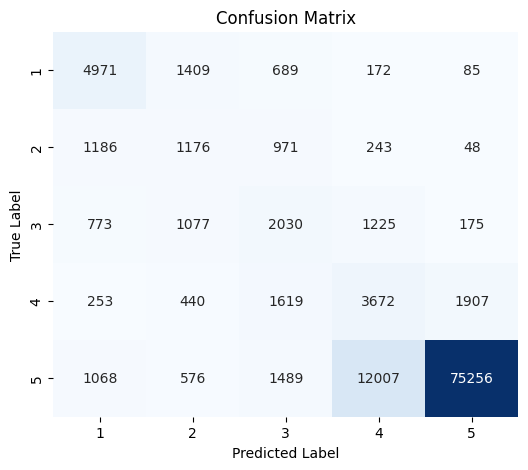

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
y_pred = pred_proba.argmax(axis=-1)
confusion_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [4]:
search_space_accuracy = {
    "objective": "multi:softprob",
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": "mlogloss",
    "num_class":5,    
    "eta": hp.uniform("eta", 0.01, 0.3),
    "gamma": hp.uniform("gamma", 0, 1.5),
    "max_depth": hp.uniformint("max_depth", 4, 7),
     "min_child_weight": hp.uniformint("min_child_weight", 3, 5),
    "lambda": hp.uniform("lambda", 1, 1.5),
    "alpha": hp.uniform("alpha", 1, 2),   
}
fine_tune_model("hyper_parameter_search_accuracy", search_space_accuracy)

NameError: name 'hp' is not defined

In [68]:
tuned_model_accuracy = pickle.load(open("best_model/classification/fine_tune_accuracy.pkl", "rb"))
print(tuned_model_accuracy.best_iteration)
pred_proba = tuned_model_accuracy.predict(dmatrix_val, iteration_range=(0, tuned_model_accuracy.best_iteration))
metrics = get_scores(y_val, pred_proba)
print(metrics)

2685
{'loss': -0.5394096992859267, 'accuracy': 0.5394096992859267, 'precision': 0.522747424640674, 'recall': 0.5394131565650708, 'f1': 0.524052768171024}


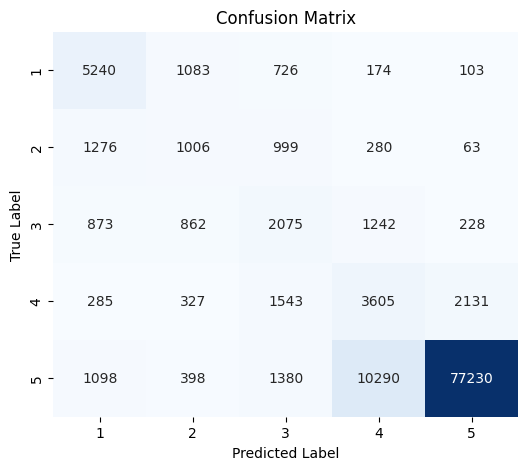

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
y_pred = pred_proba.argmax(axis=-1)
confusion_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [5]:
search_space_accuracy_2 = {
    "objective": "multi:softprob",
     "booster": "gbtree",
    "device": "gpu",    
    "tree_method": "hist",
    "eval_metric": "mlogloss",
    "num_class":5,    
    "eta": hp.uniform("eta", 0.025, 0.035),
    "gamma": hp.uniform("gamma", 0.2, 0.3),
    "max_depth": hp.uniformint("max_depth", 2, 5),
     "min_child_weight": hp.uniformint("min_child_weight", 2, 4),
    "lambda": hp.uniform("lambda", 1.35, 1.5),
    "alpha": hp.uniform("alpha", 1.25, 1.35),   
}
fine_tune_model("hyper_parameter_search_accuracy_2", search_space_accuracy_2)

NameError: name 'hp' is not defined